## Conv2D

In [51]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [52]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [53]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

import tensorflow as tf
from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel
from tensorflow.keras.callbacks import ModelCheckpoint

In [54]:
WINDOW_SIZE = 6000 # in milliseconds
KERNEL_LENGTH = 10 #in sample data points
KERNEL_HEIGHT = 2
FREQUENCY = 40 # in milliseconds
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY
print("SAMPLE_SIZE =", SAMPLE_SIZE)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

SAMPLE_SIZE = 150


### Prepare data

In [55]:
RAW_FILES = ['neureuth'] # Multiple Sessions ['neureuth', 'anothersession']
VAL_FILE = 'neureuth'

In [56]:
X_train = None
y_train = None
for raw_file in RAW_FILES:
    X, y = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY)
    X = MtbDataProvider.sync_sensors(X)
    X, y = MtbDataProvider.slice_sensors(X, y, window_size=WINDOW_SIZE, frequency=FREQUENCY, step_size=.25)
    
    if X_train is None:
        X_train = X
        y_train = y
    else:
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

X_train.shape #(slices_count, slice_length, sensors_count, sensor_dimensions)

reading  ../data/raw/neureuth_acc_2.csv
reading  ../data/raw/neureuth_acc_1.csv
reading  ../data/raw/neureuth_gyr_2.csv
reading  ../data/raw/neureuth_gyr_1.csv


(965, 150, 4, 3)

In [57]:
# IF THERE IS NO VALIDATION SESSION (yet), split 80/20
# Do not run this multiple times in a row, because it overwrites X_train and therefore will get smaller and smaller

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=.2, random_state=RANDOM_SEED, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)

(772, 150, 4, 3) (772,)
(193, 150, 4, 3) (193,)


## PCA

In [58]:
from sklearn.decomposition import PCA

In [59]:
X_dev = X_dev.reshape((X_dev.shape[0],X_dev.shape[1]*X_dev.shape[2]*X_dev.shape[3]))
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_train.shape

(772, 1800)

In [60]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train) 
X_dev = pca.fit_transform(X_dev) 


## K-Means

In [61]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=RANDOM_SEED).fit(X_train)
y_pred_dev = kmeans.predict(X_dev)
y_pred_train = kmeans.predict(X_train)

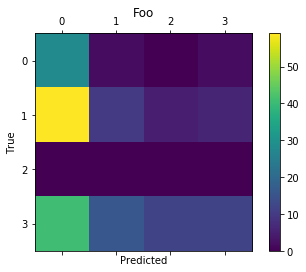

In [62]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev, labels=[0,1,2,3])

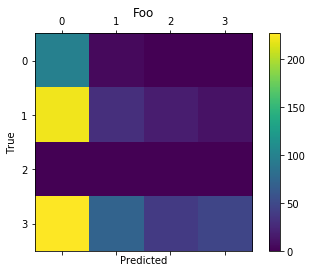

In [63]:
MtbVisualizer.print_confusion_matrix(y_train, y_pred_train, labels=[0,1,2,3])